In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare 

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

np.random.seed(123)

In [2]:
df = acquire.get_zillow_data()
df = prepare.remove_outliers(df)
df = prepare.handle_nulls(df)
df = prepare.rename_columns(df)
df = prepare.prepare_locs(df)

In [3]:
#df = df.where(df.propertycountylandusecode == '0101')

In [4]:
#df = df.dropna()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47936 entries, 0 to 52440
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   47936 non-null  int64         
 1   bathrooms                  47936 non-null  float64       
 2   bedrooms                   47936 non-null  float64       
 3   square_feet                47936 non-null  int64         
 4   fips                       47936 non-null  int64         
 5   garages                    47936 non-null  int64         
 6   garage_size                47936 non-null  int64         
 7   lot_size                   47936 non-null  int64         
 8   has_pool                   47936 non-null  bool          
 9   propertycountylandusecode  47936 non-null  object        
 10  propertylandusetypeid      47936 non-null  float64       
 11  year_built                 47936 non-null  int64         
 12  taxv

In [6]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)
# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

def printmd(string): # function to format text style
    display(Markdown(string))
print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Validate Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Test Records:** {:,}'
     .format(len(test)))
# returns the amount of records in each subset after splitting

**Number of Train Records:** 26,843

**Number of Validate Records:** 11,505

**Number of Test Records:** 9,588

In [7]:
train.propertycountylandusecode.value_counts()

0100    13648
122      6863
0101     3157
1111     1851
1110      506
1         505
0104      202
010M       30
0103       27
010G       24
0108       22
0109        5
0105        1
1112        1
0131        1
Name: propertycountylandusecode, dtype: int64

In [8]:
bins = [-.6, -.0475, -.0244, -.0106, 0, .0125, .0283, .0586, .6]
labels = ['N4','N3','N2','N1', 'P1', 'P2', 'P3', 'P4']
train['log_error_bin'] = pd.cut(train['log_error'], bins=bins, labels=labels)
validate['log_error_bin'] = pd.cut(validate['log_error'], bins=bins, labels=labels)
test['log_error_bin'] = pd.cut(test['log_error'], bins=bins, labels=labels)

In [9]:
bins = [0, 1214, 1497, 1850, 2430, 5600]
labels = ['XS','S','M','L', 'XL']
train['square_feet_bin'] = pd.cut(train['square_feet'], bins=bins, labels=labels)
validate['square_feet_bin'] = pd.cut(validate['square_feet'], bins=bins, labels=labels)
test['square_feet_bin'] = pd.cut(test['square_feet'], bins=bins, labels=labels)

In [10]:
train_neg = train.where(train.log_error < 0)
train_pos = train.where(train.log_error > 0)

In [11]:
train_neg = train_neg.dropna()
train_pos = train_pos.dropna()

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [13]:
bins = [0, .0141, .0322, .0674, .6]
labels = ['P1', 'P2', 'P3', 'P4']
train_pos['log_error_bin'] = pd.cut(train_pos['log_error'], bins=bins, labels=labels)

In [14]:
bins = [-.6, -.0609, -.0293, -.01278, 0]
labels = ['N4','N3','N2','N1']
train_neg['log_error_bin'] = pd.cut(train_neg['log_error'], bins=bins, labels=labels)

In [15]:
train["size_and_error"] = train[['square_feet_bin','log_error_bin']].agg('-'.join, axis=1)

In [16]:
train['size_and_error'].where(train.size_and_error.str.contains("P2")).value_counts().sort_values()

XS-P2    603
S-P2     663
M-P2     672
XL-P2    729
L-P2     825
Name: size_and_error, dtype: int64

In [17]:
bins = [1900, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2020]
labels = ['1910s','1920s','1930s','1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', ]
train['year_bin'] = pd.cut(train['year_built'], bins=bins, labels=labels)
validate['year_bin'] = pd.cut(train['year_built'], bins=bins, labels=labels)
test['year_bin'] = pd.cut(train['year_built'], bins=bins, labels=labels)

In [18]:
train["year_and_error"] = train[['year_bin','log_error_bin']].agg('-'.join, axis=1)

In [19]:
train['year_and_error'].where(train.size_and_error.str.contains("N1")).value_counts().sort_values()

1910s-N1     16
1930s-N1     74
1920s-N1    100
2000s-N1    198
1990s-N1    223
1980s-N1    255
1940s-N1    262
1970s-N1    334
1960s-N1    413
1950s-N1    583
Name: year_and_error, dtype: int64

In [20]:
train["both_error"] = train[['year_bin', 'square_feet_bin', 'log_error_bin']].agg('-'.join, axis=1)

In [21]:
train['both_error'].where(train.size_and_error.str.contains("P1")).value_counts().sort_values()

1910s-XL-P1      2
2000s-XS-P1      4
1910s-M-P1       4
1910s-L-P1       4
1990s-XS-P1      5
2000s-S-P1       6
1920s-XL-P1      7
1930s-XL-P1      9
1910s-S-P1      11
1910s-XS-P1     13
1930s-L-P1      14
1940s-XL-P1     15
1920s-L-P1      15
1930s-XS-P1     20
1920s-M-P1      20
1930s-S-P1      21
1980s-XS-P1     24
1930s-M-P1      24
1990s-S-P1      25
2000s-M-P1      27
1940s-L-P1      28
1920s-S-P1      31
1970s-XS-P1     32
1950s-XL-P1     35
1990s-M-P1      47
1960s-XS-P1     48
1980s-S-P1      54
1940s-M-P1      55
1920s-XS-P1     68
1960s-XL-P1     69
2000s-L-P1      77
1940s-S-P1      77
1980s-M-P1      85
1970s-XL-P1     89
1990s-L-P1      98
1970s-M-P1      99
1980s-L-P1     105
1980s-XL-P1    106
1950s-L-P1     112
1970s-S-P1     114
1970s-L-P1     131
1960s-L-P1     132
1990s-XL-P1    138
1960s-S-P1     147
1960s-M-P1     154
1940s-XS-P1    162
2000s-XL-P1    174
1950s-XS-P1    202
1950s-M-P1     204
1950s-S-P1     255
Name: both_error, dtype: int64

<AxesSubplot:xlabel='year_bin', ylabel='count'>

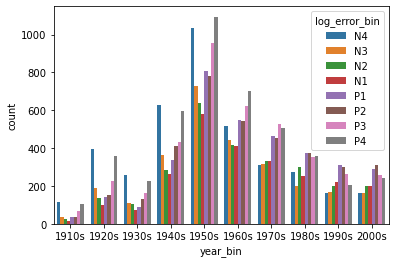

In [22]:
sns.countplot(data=train, x='year_bin', hue='log_error_bin')

In [23]:
#since 1970, log errors are more overshooting than under

<AxesSubplot:xlabel='year_bin', ylabel='count'>

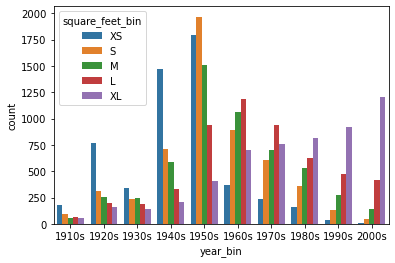

In [24]:
sns.countplot(data=train, x='year_bin', hue='square_feet_bin')

<AxesSubplot:xlabel='square_feet_bin', ylabel='count'>

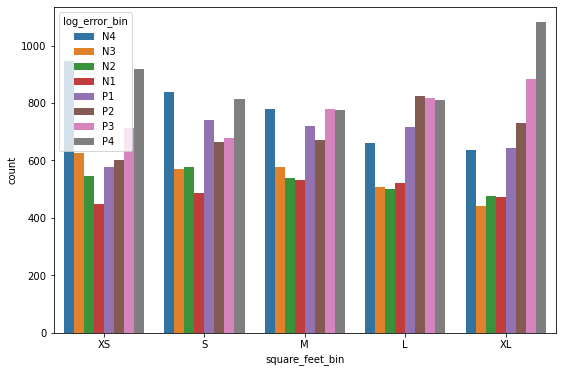

In [25]:
plt.figure(figsize=(9, 6))
sns.countplot(data=train, x='square_feet_bin', hue='log_error_bin')

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

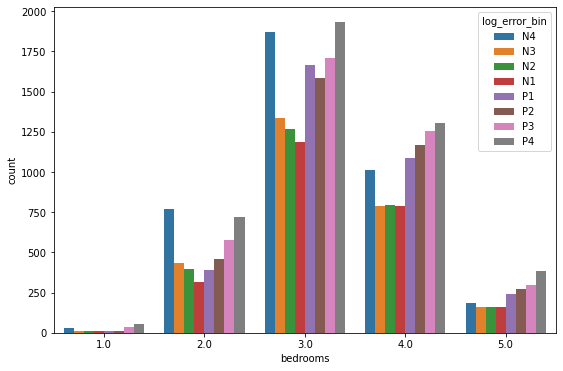

In [26]:
plt.figure(figsize=(9, 6))
sns.countplot(data=train, x='bedrooms', hue='log_error_bin')

In [27]:
train.lot_size.quantile(.99)

56630.31999999999

In [28]:
bins = [0, 5272, 6299, 7368, 9518, 56700, 100000000]
labels = ['XS','S','M','L', 'XL', 'NO']
train['lot_size_bin'] = pd.cut(train['lot_size'], bins=bins, labels=labels)
validate['lot_size_bin'] = pd.cut(validate['lot_size'], bins=bins, labels=labels)
test['lot_size_bin'] = pd.cut(test['lot_size'], bins=bins, labels=labels)

<AxesSubplot:xlabel='lot_size_bin', ylabel='count'>

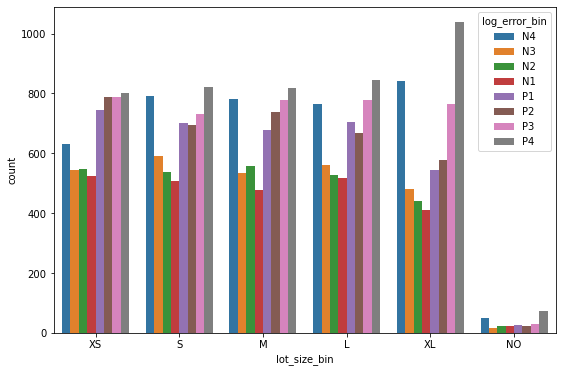

In [29]:
plt.figure(figsize=(9, 6))
sns.countplot(data=train, x='lot_size_bin', hue='log_error_bin')

<AxesSubplot:xlabel='year_bin', ylabel='count'>

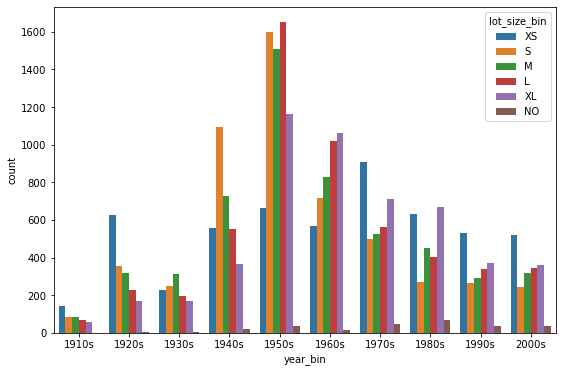

In [30]:
plt.figure(figsize=(9, 6))
sns.countplot(data=train, x='year_bin', hue='lot_size_bin')

<Figure size 648x432 with 0 Axes>

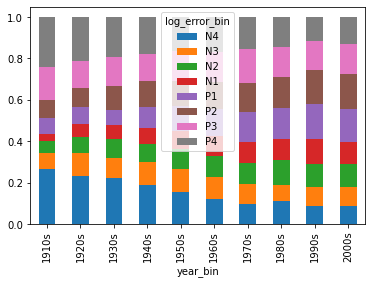

In [31]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['year_bin'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

<Figure size 648x432 with 0 Axes>

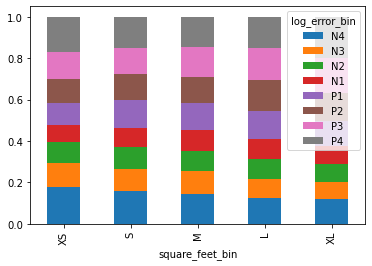

In [32]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['square_feet_bin'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

In [33]:
plt.rcParams["figure.figsize"] = (15,8)

<Figure size 648x432 with 0 Axes>

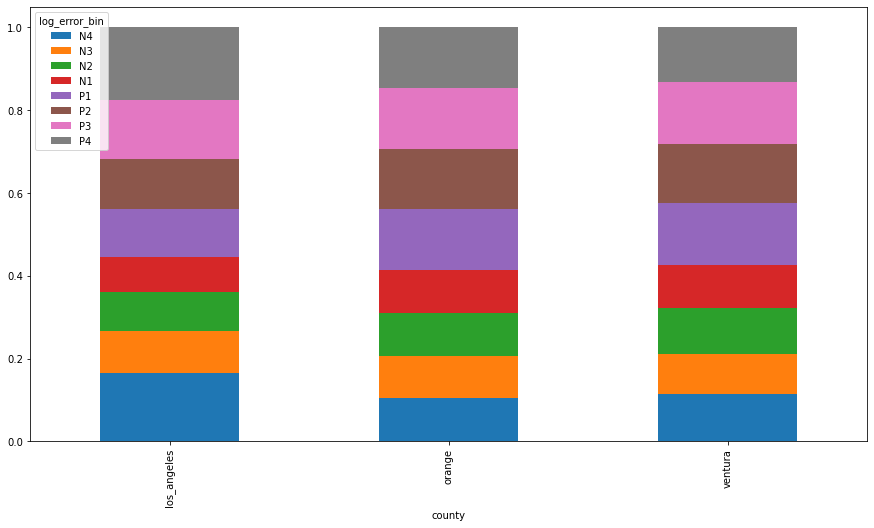

In [34]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['county'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

<Figure size 648x432 with 0 Axes>

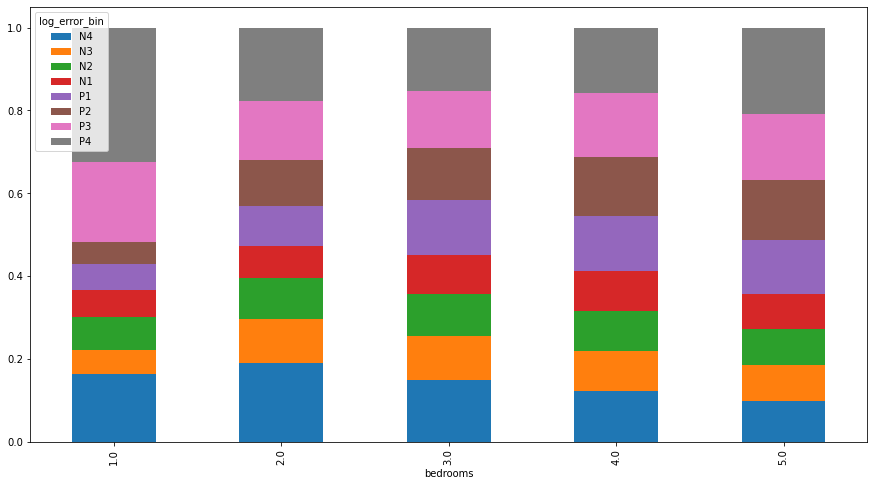

In [35]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['bedrooms'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

<Figure size 648x432 with 0 Axes>

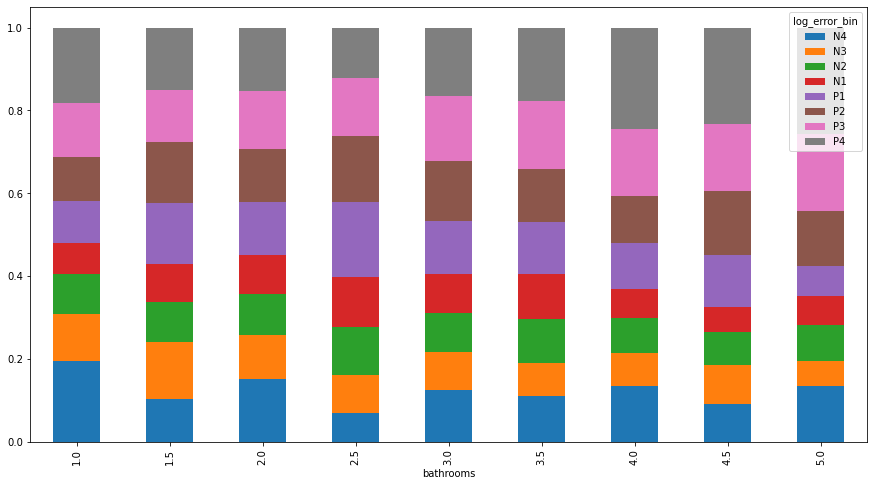

In [36]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['bathrooms'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

<Figure size 648x432 with 0 Axes>

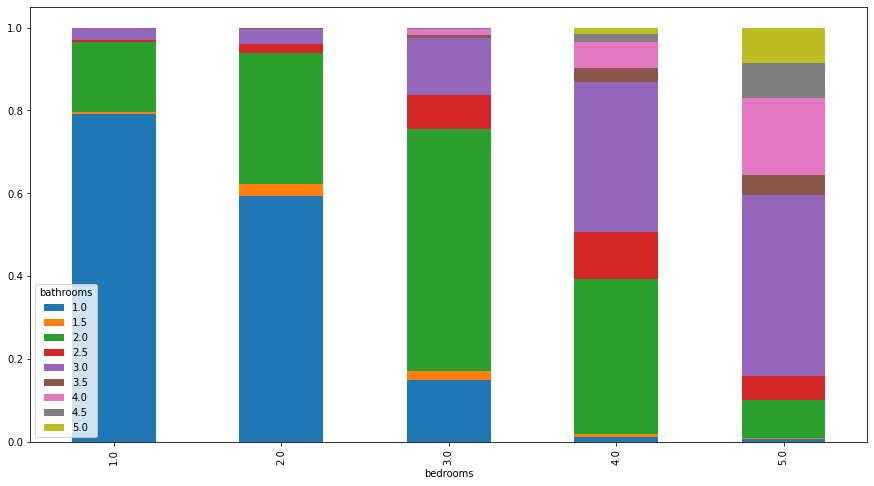

In [37]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['bedrooms'],train['bathrooms'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

<Figure size 648x432 with 0 Axes>

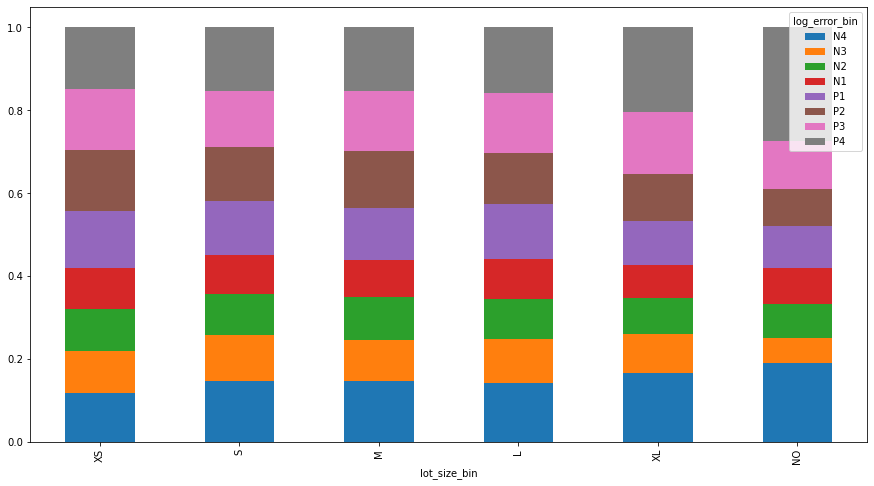

In [38]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['lot_size_bin'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26843 entries, 25090 to 1588
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   26843 non-null  int64         
 1   bathrooms                  26843 non-null  float64       
 2   bedrooms                   26843 non-null  float64       
 3   square_feet                26843 non-null  int64         
 4   fips                       26843 non-null  int64         
 5   garages                    26843 non-null  int64         
 6   garage_size                26843 non-null  int64         
 7   lot_size                   26843 non-null  int64         
 8   has_pool                   26843 non-null  bool          
 9   propertycountylandusecode  26843 non-null  object        
 10  propertylandusetypeid      26843 non-null  float64       
 11  year_built                 26843 non-null  int64         
 12  t

<Figure size 648x432 with 0 Axes>

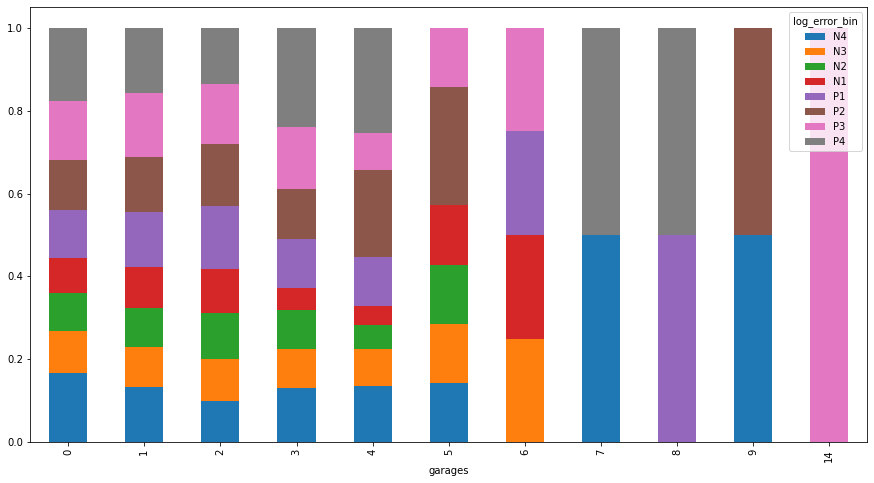

In [40]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['garages'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

<Figure size 648x432 with 0 Axes>

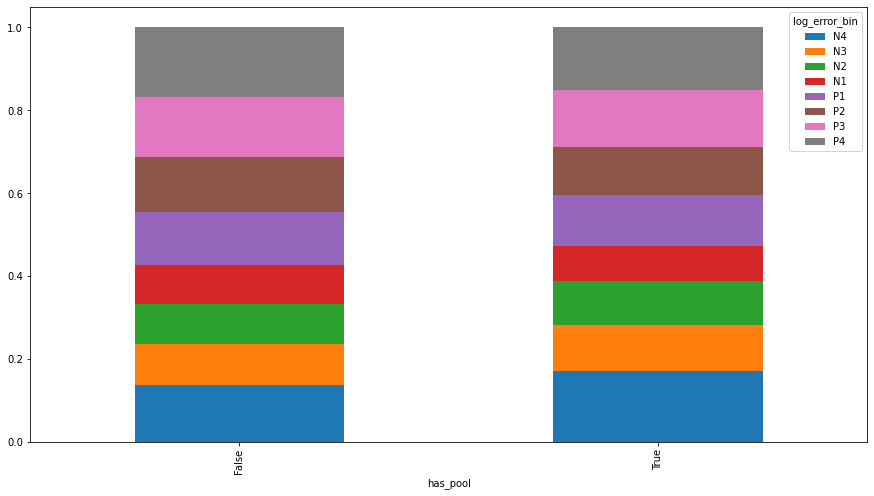

In [41]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['has_pool'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

<Figure size 648x432 with 0 Axes>

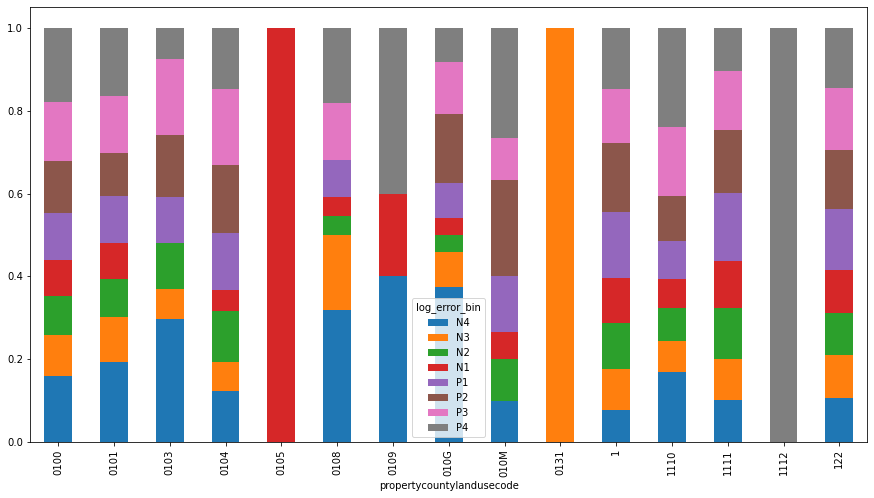

In [42]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['propertycountylandusecode'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()


In [43]:
train.propertycountylandusecode.value_counts()

0100    13648
122      6863
0101     3157
1111     1851
1110      506
1         505
0104      202
010M       30
0103       27
010G       24
0108       22
0109        5
0105        1
1112        1
0131        1
Name: propertycountylandusecode, dtype: int64

In [44]:
train = train[(train.propertycountylandusecode != '0109') & (train.propertycountylandusecode != '0105') & (train.propertycountylandusecode != '1112') & (train.propertycountylandusecode != '0131')]
validate = validate[(validate.propertycountylandusecode != '0109') & (validate.propertycountylandusecode != '0105') & (validate.propertycountylandusecode != '1112') & (validate.propertycountylandusecode != '0131')]
test = test[(test.propertycountylandusecode != '0109') & (test.propertycountylandusecode != '0105') & (test.propertycountylandusecode != '1112') & (test.propertycountylandusecode != '0131')]

<Figure size 648x432 with 0 Axes>

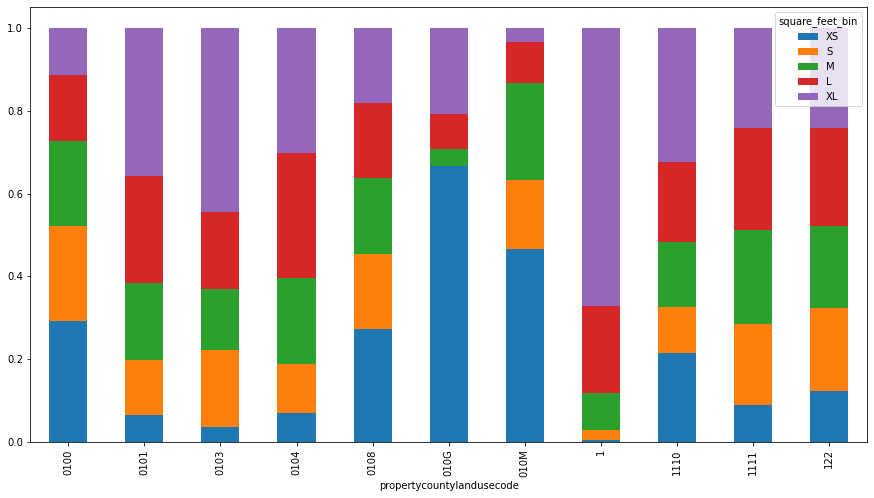

In [45]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['propertycountylandusecode'],train['square_feet_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

In [46]:
continuous = train[['bathrooms', 'bedrooms', 'square_feet', 'garages', 'garage_size', 'lot_size', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
train_neg = train.where(train.log_error < 0)
train_pos = train.where(train.log_error > 0)

In [47]:
train_neg= train_neg.dropna()
train_pos = train_pos.dropna()

In [48]:
cn = train_neg[['log_error','bathrooms', 'bedrooms', 'square_feet', 'garages', 'garage_size', 'lot_size', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
cp = train_pos[['log_error', 'bathrooms', 'bedrooms', 'square_feet', 'garages', 'garage_size', 'lot_size', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]

<AxesSubplot:title={'center':'Feature Correlation (contiuous variables) of to Log Error'}>

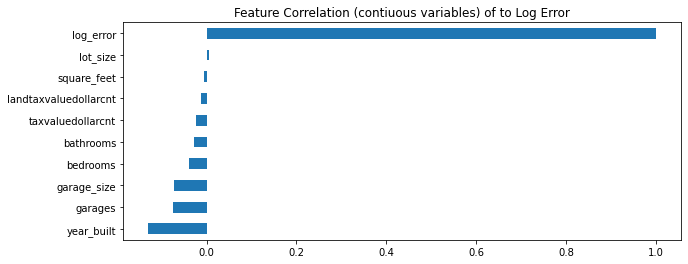

In [49]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation (contiuous variables) of to Log Error")
corr_chart = cp.corrwith(cp['log_error']).sort_values().plot.barh()
corr_chart

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26835 entries, 25090 to 1588
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   26835 non-null  int64         
 1   bathrooms                  26835 non-null  float64       
 2   bedrooms                   26835 non-null  float64       
 3   square_feet                26835 non-null  int64         
 4   fips                       26835 non-null  int64         
 5   garages                    26835 non-null  int64         
 6   garage_size                26835 non-null  int64         
 7   lot_size                   26835 non-null  int64         
 8   has_pool                   26835 non-null  bool          
 9   propertycountylandusecode  26835 non-null  object        
 10  propertylandusetypeid      26835 non-null  float64       
 11  year_built                 26835 non-null  int64         
 12  t

In [51]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'lot_size']])
# inserts the 4 selected features into the scaler

train_s = train[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'lot_size']]
validate_s  = validate[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'lot_size']]
test_s = test[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'lot_size']]

train_scal = scaler.transform(train[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'lot_size']])
validate_scal  = scaler.transform(validate[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'lot_size']])
test_scal  = scaler.transform(test[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'lot_size']])

In [52]:
X_train_scaled = pd.DataFrame(train_scal, index=train_s.index, columns=train_s.columns)
X_validate_scaled = pd.DataFrame(validate_scal, index=validate_s.index, columns=validate_s.columns)
X_test_scaled = pd.DataFrame(test_scal, index=test_s.index, columns=test_s.columns)

In [53]:
dummy_train = pd.get_dummies(train['propertycountylandusecode'])
dummy_validate = pd.get_dummies(validate['propertycountylandusecode'])
dummy_test = pd.get_dummies(test['propertycountylandusecode'])

In [54]:
X_train = pd.concat([X_train_scaled, dummy_train], axis=1)
X_validate = pd.concat([X_validate_scaled, dummy_validate], axis=1)
X_test = pd.concat([X_test_scaled, dummy_test], axis=1)

y_train = train[['log_error']]
y_validate = validate[['log_error']]
y_test = test[['log_error']] 

In [55]:
X_validate.drop(columns=['0110', '0102'], inplace=True)

In [56]:
X_validate.head()

,bedrooms,bathrooms,year_built,taxvaluedollarcnt,landtaxvaluedollarcnt,lot_size,0100,0101,0103,0104,0108,010G,010M,1,1110,1111,122
36051,0.5,0.000,0.066038,0.011718,0.014671,0.000866,1,0,0,0,0,0,0,0,0,0,0
30938,0.5,0.250,0.660377,0.135332,0.119918,0.000947,1,0,0,0,0,0,0,0,0,0,0
5205,0.5,0.000,0.094340,0.069212,0.068559,0.000496,1,0,0,0,0,0,0,0,0,0,0
43711,0.5,0.250,0.018868,0.139696,0.130869,0.000927,1,0,0,0,0,0,0,0,0,0,0
36910,0.5,0.375,0.603774,0.113678,0.064186,0.000577,0,0,0,0,0,0,0,0,0,0,1


In [57]:
y_train['pred_mean'] = y_train.log_error.mean()
y_validate['pred_mean'] = y_validate.log_error.mean()

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_mean)**(1/2)

print("Baseline RMSE\nTrain/In-Sample: ", round(rmse_train, 6)), 
print("Baseline RMSE\nValidate/Out-of-Sample: ", round(rmse_validate, 6))

Baseline RMSE
Train/In-Sample:  0.083535
Baseline RMSE
Validate/Out-of-Sample:  0.084292


In [64]:
lm = LinearRegression(normalize=False)

lm.fit(X_train, y_train.log_error)

y_train['value_predict_lm'] = lm.predict(X_train)

rmse_train = mean_squared_error(y_train.log_error, y_train.value_predict_lm)**(1/2)

y_validate['value_predict_lm'] = lm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_predict_lm)**(1/2)


printmd("**OLS Linear Regression Performance**")
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 6))
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nValidation/Out-of-Sample: ", round(rmse_validate, 6))

**OLS Linear Regression Performance**

---------------------------------------
RMSE for OLS using LinearRegression
Training/In-Sample:  0.083328
---------------------------------------
RMSE for OLS using LinearRegression
Validation/Out-of-Sample:  0.084237


In [59]:
lars = LassoLars(alpha=1.5)

lars.fit(X_train, y_train.log_error)

y_train['pred_lars'] = lars.predict(X_train)

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_lars)**(1/2)

y_validate['pred_lars'] = lars.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_lars)**(1/2)

printmd("**LARS Performance**")
print("---------------------------------------")
print("RMSE for Lars\nTraining/In-Sample: ", round(rmse_train, 6))
print("---------------------------------------")
print("RMSE for Lars\nOut-of-Sample: ", round(rmse_validate, 6))

**LARS Performance**

---------------------------------------
RMSE for Lars
Training/In-Sample:  0.083535
---------------------------------------
RMSE for Lars
Out-of-Sample:  0.084293


In [76]:
pf = PolynomialFeatures(degree=3)
# creates polynomial features to use in model with degree of 3

X_train_degree3 = pf.fit_transform(X_train)
# fit and transform X_train_scaled

X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)
#transform X_validate_scaled & X_test_scaled

In [77]:

lm3 = LinearRegression(normalize=False)
# creates linear regression model prior to fitting with new polynomial features

lm3.fit(X_train_degree3, y_train.log_error)
# fit and transform polynomial features and target

y_train['value_pred_lm3'] = lm3.predict(X_train_degree3)
# predictions calculated on train

rmse_train = mean_squared_error(y_train.log_error, y_train.value_pred_lm3)**(1/2)
# computes rmse with train

y_validate['value_pred_lm3'] = lm3.predict(X_validate_degree3)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_pred_lm3)**(1/2)
# computes predictions/rmse with validate

printmd("**Polynomial Regression Model Performance**")
print("---------------------------------------")
print("RMSE for Polynomial Model \nTraining/In-Sample: ", round(rmse_train, 4)),
print("---------------------------------------")
print("RMSE for Polynomial Model, \nValidation/Out-of-Sample: ", round(rmse_validate, 4))

**Polynomial Regression Model Performance**

---------------------------------------
RMSE for Polynomial Model 
Training/In-Sample:  0.0823
---------------------------------------
RMSE for Polynomial Model, 
Validation/Out-of-Sample:  683209140.8979


In [78]:
glm = TweedieRegressor (power= 0, alpha=1) #, alpha=1)
# creates the model

glm.fit(X_train, y_train.log_error)
# fit the model to scaled training data

y_train['pred_value_glm'] = glm.predict(X_train)
# computes model predictions
rmse_train = mean_squared_error(y_train.log_error, y_train.pred_value_glm)**(1/2)
# computes model rmse

y_validate['pred_value_glm'] = glm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_value_glm)**(1/2)
# comutes predictions and rmse with validate data

printmd("**Generalized Linear Model Performance**")
print("---------------------------------------")
print("RMSE for GLM /In-Sample: ", round(rmse_train, 6)), 
print("---------------------------------------")
print("RMSE for GLM \nValidation/Out-of-Sample: ", round(rmse_validate, 6))

**Generalized Linear Model Performance**

---------------------------------------
RMSE for GLM /In-Sample:  0.083516
---------------------------------------
RMSE for GLM 
Validation/Out-of-Sample:  0.084278


combining features:
    - rooms (bed, bath)
    - size (square, lot, garage)
    - extras (pool, garage)
    - year
    - location & (code)
    